<a href="https://colab.research.google.com/github/Benylaode/clasification_plant_tf/blob/main/seed_clasification_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**melakukan peninstallan depedensi tensorflowjs untuk proses penyimpanan model**

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


**mengimport beberapadepedensi yang di butuhakan**

In [16]:
import os
from google.colab import drive
import shutil
import random
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import shutil
from google.colab import files

**melakukan koneksi ke drive**

In [3]:
shutil.rmtree('/content/drive', ignore_errors=True)

In [4]:

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
data_all = '/content/drive/MyDrive/plant-seedlings-classification/'

**melakukan split dataset**

In [6]:
base_path = Path(data_all)
merged_path = base_path / "train"
split_base = base_path / "split"

def validate_split_structure(split_path, expected_classes):
    if not split_path.exists():
        return False

    for subset in ["train", "val", "test"]:
        subset_path = split_path / subset
        if not subset_path.exists():
            return False

        existing_classes = {d.name for d in subset_path.iterdir() if d.is_dir()}
        if existing_classes != expected_classes:
            return False

        for cls in expected_classes:
            cls_path = subset_path / cls
            if not any(cls_path.iterdir()):
                return False

    return True


expected_classes = set()
if merged_path.exists():
    expected_classes = {d.name for d in merged_path.iterdir() if d.is_dir()}
elif (split_base / "train").exists():
    expected_classes = {d.name for d in (split_base / "train").iterdir() if d.is_dir()}

if not expected_classes:
    raise ValueError("Tidak ditemukan data kelas baik di folder merged maupun split")

if merged_path.exists():
    print("Folder merged ditemukan. Memproses pembagian data (COPY)...")

    if split_base.exists():
        print("Menghapus struktur split lama...")
        shutil.rmtree(split_base)

    print("Membuat struktur folder baru...")
    for subset in ["train", "val", "test"]:
        (split_base / subset).mkdir(parents=True)

    for cls in expected_classes:
        for subset in ["train", "val", "test"]:
            (split_base / subset / cls).mkdir(parents=True)

    print("Memulai pembagian data (copy)...")
    for cls in expected_classes:
        class_files = list((merged_path / cls).glob("*"))
        random.shuffle(class_files)

        total_files = len(class_files)
        train_split = int(0.7 * total_files)
        val_split = train_split + int(0.15 * total_files)


        for i, f in enumerate(class_files):
            if i < train_split:
                dest = split_base / "train" / cls / f.name
            elif i < val_split:
                dest = split_base / "val" / cls / f.name
            else:
                dest = split_base / "test" / cls / f.name
            shutil.copy2(f, dest)

    print("Data berhasil di-copy ke folder split. Data asli di merged tetap utuh.")

elif validate_split_structure(split_base, expected_classes):
    print("Folder split sudah ada dan valid. Data asli tidak diubah.")
else:
    raise ValueError("Folder merged tidak ada dan struktur split tidak valid")

print("\nStatistik akhir:")
print(f"Total kelas: {len(expected_classes)}")
for subset in ["train", "val", "test"]:
    subset_path = split_base / subset
    num_files = sum(1 for _ in subset_path.rglob("*") if _.is_file())
    num_classes = len([d for d in subset_path.iterdir() if d.is_dir()])
    print(f"{subset.upper()}: {num_files} file | {num_classes} kelas")

Folder merged ditemukan. Memproses pembagian data (COPY)...
Membuat struktur folder baru...
Memulai pembagian data (copy)...
Data berhasil di-copy ke folder split. Data asli di merged tetap utuh.

Statistik akhir:
Total kelas: 12
TRAIN: 3319 file | 12 kelas
VAL: 708 file | 12 kelas
TEST: 723 file | 12 kelas


**definsiikan beberapa dataset dari folder yang sudah di split dari dataset**

In [7]:
img_size = (150, 150)
batch_size = 32
base_dir = split_base

datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)
val_generator = datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)
test_generator = datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)




Found 3319 images belonging to 12 classes.
Found 708 images belonging to 12 classes.
Found 723 images belonging to 12 classes.


**pendefinsian model**

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU

model = Sequential([
    Conv2D(64, (7, 7), strides=2, padding='same', input_shape=(150, 150, 3)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((3, 3), strides=2, padding='same'),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(128, (3, 3), strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(256, (3, 3), strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),


    Conv2D(512, (3, 3), strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001, weight_decay=0.01),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


model di atas disusun dalam beberapa layer dengan penekanan pada model cnn sederhana dengan pendefinsian conv2d untuk melakukan extrasi fitur dengan memanfaatkan pooling layer di layer pertama  tepatnya maxpooling untuk mengurangi dimensi

**pelatihan dengan teknik OneCycleScheduler agar sedikit model bisa maksimal**

In [9]:
class OneCycleScheduler(Callback):
    def __init__(self, max_lr=1e-3, total_steps=None, epochs=None, steps_per_epoch=None,
                 pct_start=0.3, div_factor=25., final_div_factor=1e4):
        super().__init__()
        self.max_lr = max_lr
        self.total_steps = total_steps if total_steps else epochs * steps_per_epoch
        self.pct_start = pct_start
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.step_num = 0
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.optimizer = self.model.optimizer
        self.init_lr = self.max_lr / self.div_factor
        self.final_lr = self.max_lr / self.final_div_factor
        self.half_step = int(self.total_steps * self.pct_start)
        self.step_size = (self.max_lr - self.init_lr) / self.half_step

    def on_batch_begin(self, batch, logs=None):
        if self.step_num < self.half_step:
            lr = self.init_lr + self.step_num * self.step_size
            mom = 0.95 - 0.85 * (self.step_num / self.half_step)
        else:
            lr = self.max_lr - (self.step_num - self.half_step) * (
                (self.max_lr - self.final_lr) / (self.total_steps - self.half_step))
            mom = 0.85 + 0.1 * ((self.step_num - self.half_step) /
                               (self.total_steps - self.half_step))

        self.optimizer.learning_rate = lr
        if hasattr(self.optimizer, 'momentum'):
            self.optimizer.momentum = mom
        elif hasattr(self.optimizer, 'beta_1'):  # For Adam
            self.optimizer.beta_1 = mom

        self.lrs.append(lr)
        self.moms.append(mom)
        self.step_num += 1

**pelatihan dan pendefinsian ulang**

In [10]:

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)
epochs = 20

one_cycle = OneCycleScheduler(max_lr=1e-3,
                             epochs=epochs,
                             steps_per_epoch=steps_per_epoch,
                             pct_start=0.3)

history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[one_cycle]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 93s 719ms/step - accuracy: 0.1864 - loss: 2.6001 - val_accuracy: 0.0607 - val_loss: 2.6232
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 62s 596ms/step - accuracy: 0.5625 - loss: 1.3163 - val_accuracy: 0.0537 - val_loss: 3.4911
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 578ms/step - accuracy: 0.6850 - loss: 0.9486 - val_accuracy: 0.2076 - val_loss: 3.1728
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 578ms/step - accuracy: 0.7310 - loss: 0.8400 - val_accuracy: 0.1667 - val_loss: 6.5025
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 62s 596ms/step - accuracy: 0.7419 - loss: 0.7435 - val_accuracy: 0.4350 - val_loss: 1.7484
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 85s 630ms/step - accuracy: 0.7579 - loss: 0.7020 - val_accuracy: 0.3390 - val_loss: 10.3765
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 616ms/step - accuracy: 0.7920 - loss: 0.6263 - val_accuracy: 0.4619 - val_loss: 2.9296
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 62s 600ms/step - accuracy: 0.8512 - loss: 

**melihat learning rate schedule dan momentum schedule**

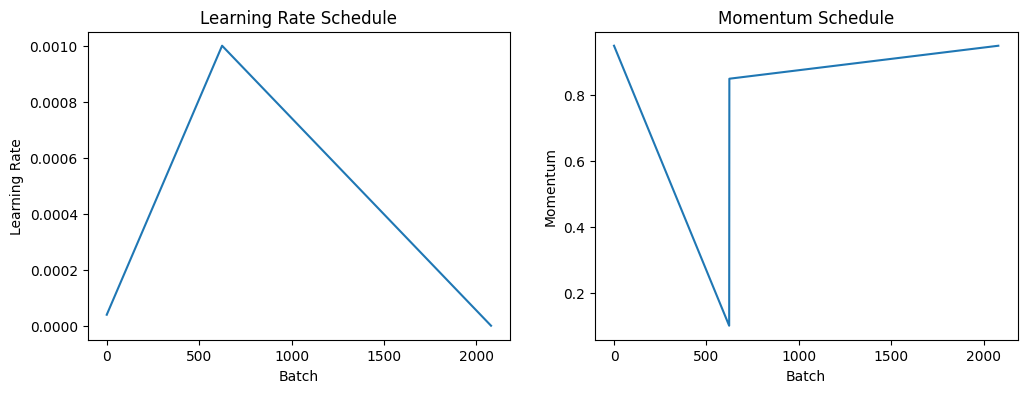

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(one_cycle.lrs)
plt.title('Learning Rate Schedule')
plt.xlabel('Batch')
plt.ylabel('Learning Rate')

plt.subplot(122)
plt.plot(one_cycle.moms)
plt.title('Momentum Schedule')
plt.xlabel('Batch')
plt.ylabel('Momentum')
plt.show()

**menampilan cm dari data set test dan juga akurasi dan loss nya dalam sebuah fungsi**

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(model, generator):

    class_names = list(generator.class_indices.keys())

    true_labels = []
    pred_labels = []

    generator.reset()
    for _ in range(len(generator)):
        x, y = next(generator)
        preds = model.predict(x, verbose=0)
        true_labels.extend(np.argmax(y, axis=1))
        pred_labels.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(true_labels, pred_labels)
    accuracy = accuracy_score(true_labels, pred_labels)
    loss = model.evaluate(generator, verbose=0)[0]

    plt.figure(figsize=(8, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, square=True)

    plt.title('Confusion Matrix (Counts)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)

    metrics_text = f"Accuracy: {accuracy:.2%} | Loss: {loss:.4f} | Samples: {len(true_labels)}"
    plt.figtext(0.5, 0.1, metrics_text, ha='center', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

**hasil pelatihan**

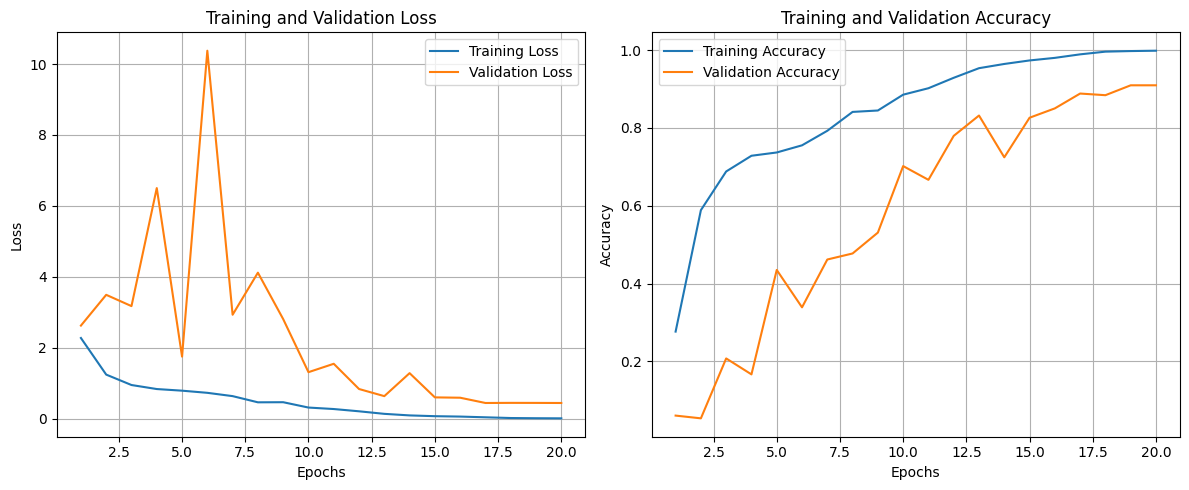

In [13]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**hasil dari cm dan akkurasi menggunakan data test**

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


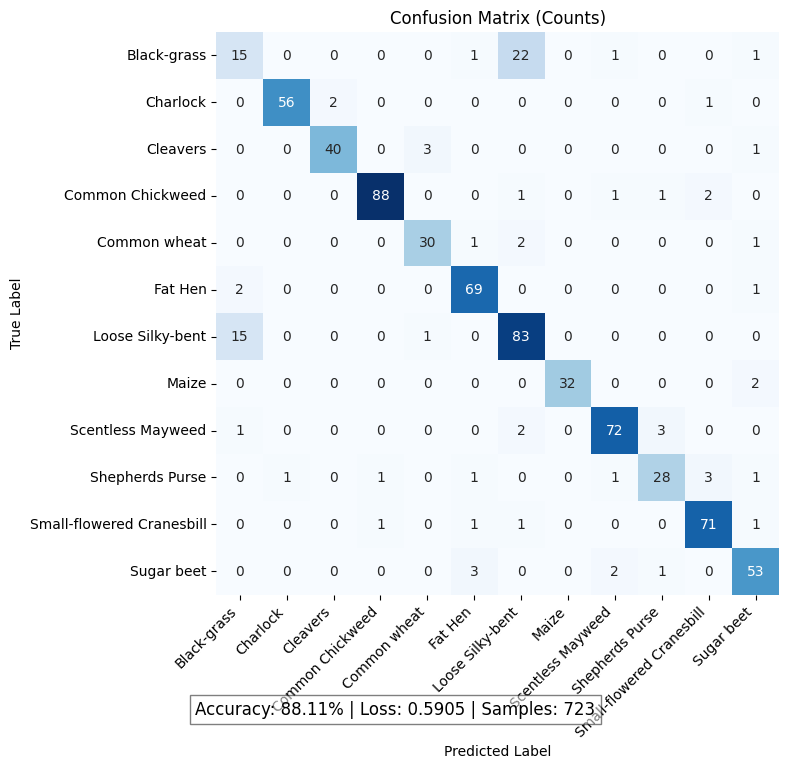

In [14]:
plot_confusion_matrix(model, test_generator)

**save model dengan format yang ditentuakn**

In [15]:
import os
import tensorflow as tf
from tensorflow import keras

os.makedirs('submission/tfjs_model', exist_ok=True)
os.makedirs('submission/tflite', exist_ok=True)
os.makedirs('submission/saved_model', exist_ok=True)

model.export('submission/saved_model/my_model')


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)


if hasattr(train_generator, 'class_indices'):
    with open('submission/tflite/label.txt', 'w') as f:
        for label in train_generator.class_indices:
            f.write(f"{label}\n")

!pip install tensorflowjs
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'submission/tfjs_model')

Saved artifact at 'submission/saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  135146327687824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135146327699920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135146327702416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135146327698960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135146327700112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135146327701648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135146327703376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135146327701456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135148296864208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135148296864784: TensorSpec(shape=(), dtype=tf.resource, name=None)


failed to lookup keras version from the file,
    this is likely a weight only file


In [17]:
folder_path = 'submission'
output_zip = 'submission.zip'

shutil.make_archive(output_zip[:-4], 'zip', folder_path)

files.download(output_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>